#

In [1]:
import pulp
import networkx as nx
import math

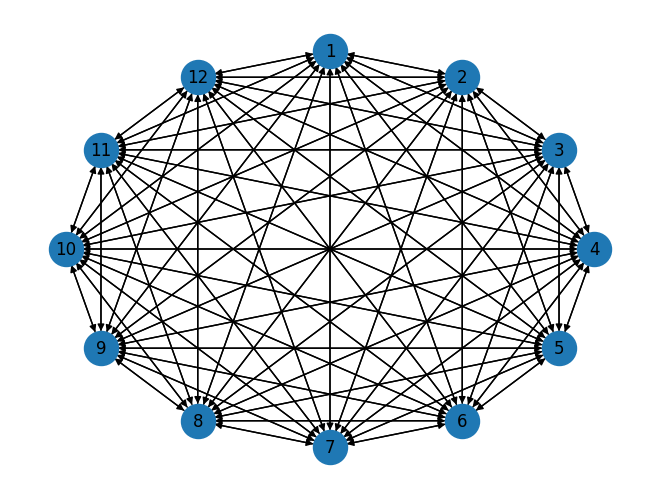

In [2]:
n=12
G = nx.complete_graph(n)

mapping = {i: i + 1 for i in G.nodes()}
G = nx.relabel_nodes(G, mapping)

G = G.to_directed()

pos = {}
for i, node in enumerate(sorted(G.nodes())):
    theta = math.pi/2 - (2*math.pi*i/n)  
    pos[node] = (math.cos(theta), math.sin(theta))
nx.draw(G, pos, with_labels=True, node_size=600)

In [3]:
labels = [l for l in range(1,n+1)]

In [4]:
prob = pulp.LpProblem("postman",pulp.LpMinimize)

# variables
x = pulp.LpVariable.dicts("x",G.edges(),cat=pulp.LpBinary)
r = pulp.LpVariable.dicts("r",G.nodes(),lowBound=1,upBound=n,cat=pulp.LpInteger)
l = pulp.LpVariable.dicts("l",G.nodes(),lowBound=1,upBound=n,cat=pulp.LpInteger)
y = pulp.LpVariable.dicts("y",(G.nodes(),labels),cat=pulp.LpBinary)

# dummy objective function
prob += pulp.lpSum((pos[u][1]-pos[v][1])**2*x[(u,v)] for (u,v) in G.edges())

# inflow and outflow through each node
for v in G.nodes():
    prob += pulp.lpSum(x[(u,v)] for u in G.nodes() if u!=v) == 1
    prob += pulp.lpSum(x[(v,u)] for u in G.nodes() if u!=v) == 1
    
# MTZ
for j in G.nodes():
    if j>1:
        for i in G.nodes():
            if i!=j:
                prob += r[j] >= r[i]+1-n*(1-x[(i,j)])

# labeling
for i in G.nodes():
    for j in G.nodes():
        if j>1:
            if i<j:
                prob += x[(i,j)] <= y[i][j-i]
            if i>j:
                prob += x[(i,j)] <= y[i][j-i+n]

    prob += pulp.lpSum(y[i][k] for k in labels) == 1
    prob += pulp.lpSum(k*y[i][k] for k in labels) == l[i]
                      
for k in labels:
    prob += pulp.lpSum(y[i][k] for i in G.nodes()) == 1

# first node
prob += r[1]==1
prob += l[1]==1

In [5]:
prob.solve()

1

In [6]:
rank_dict = dict(zip([i for i in r],[pulp.value(r[i])for i in r]))
for i in sorted(rank_dict, key=lambda k: rank_dict[k]):
    print("rank",int(pulp.value(r[i])),"node",i,"label",int(pulp.value(l[i])))

rank 1 node 1 label 1
rank 2 node 2 label 10
rank 3 node 12 label 3
rank 4 node 3 label 8
rank 5 node 11 label 5
rank 6 node 4 label 6
rank 7 node 10 label 7
rank 8 node 5 label 4
rank 9 node 9 label 9
rank 10 node 6 label 2
rank 11 node 8 label 11
rank 12 node 7 label 12

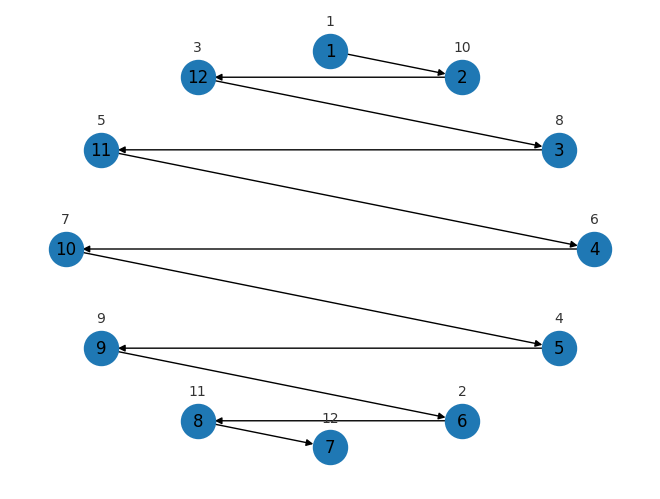

In [7]:
remove = []
for (u,v) in G.edges():
    if pulp.value(x[(u,v)])<0.1:
        remove.append((u,v))
    elif v==1:
        remove.append((u,v))
G.remove_edges_from(remove)

nx.draw(G, pos, with_labels=True, node_size=600)
offset = 0.15  
pos_value = {v: (x, y + offset) for v, (x, y) in pos.items()}
val_labels = {v: f"{int(pulp.value(l[v]))}" for v in G.nodes()}             
nx.draw_networkx_labels(G, pos_value, labels=val_labels, font_size=10, font_color="#333")